# Flare Peak Detection Machine Learning Model
This file will contain our data preprocessing, machine learning model set up, and model testing to detect flare peaks. 
 

# Most Up To Date: 
Under this section you'll find the most up to date model.

# Previous Attempts: 
Under here you'll have access to some of our previous attempts.  

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


2023-11-28 13:46:15.768651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data: Random Shuffle 
In this approach, 

In [62]:

"path = "../data/sliding_wide_100.csv"

full_set = pd.read_csv(path)
full_set.head()
"

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,Label
0,1.536445e-09,3.079428e-09,2.603944e-09,2.551378e-09,2.558685e-09,1.432635e-09,1.874788e-09,2.721542e-09,4.285158e-09,3.629239e-09,...,2.856966e-09,4.389429e-09,3.694770e-09,4.274082e-09,3.263311e-09,4.095904e-09,4.768051e-09,2.979967e-09,3.660248e-09,0
1,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.526971e-09,1.000000e-09,1.000000e-09,1.649339e-09,1.540821e-09,1.000000e-09,1.000000e-09,1.541843e-09,1.000000e-09,0
2,5.248012e-09,5.624901e-09,6.257582e-09,5.772275e-09,6.182636e-09,6.658299e-09,6.329365e-09,4.159591e-09,4.723101e-09,4.167188e-09,...,5.897906e-09,5.774463e-09,5.901859e-09,7.200517e-09,6.219275e-09,6.868841e-09,6.631912e-09,5.008209e-09,6.311808e-09,0
3,1.000000e-09,1.996967e-09,1.357384e-09,1.118515e-09,1.433971e-09,1.508355e-09,2.165851e-09,1.193197e-09,1.000000e-09,1.135763e-09,...,1.270822e-09,1.173274e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,0
4,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.603935e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,0


In [63]:
"""
# Train, test, val splits
X = full_set.iloc[:, :-1].values
y = full_set.iloc[:, -1].values

# Split the data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
"""

In [64]:
# X_train.shape[0], X_val.shape[0], X_test.shape[0]

(21204, 4544, 4544)

In [65]:
# full_set.shape[0]

30292

In [66]:
# X_train[0]

array([4.8552640e-08, 4.8575348e-08, 4.8590100e-08, 4.3660503e-08,
       5.0097253e-08, 4.8511280e-08, 4.6309523e-08, 4.7605354e-08,
       5.0638540e-08, 5.3045070e-08, 5.9455978e-08, 7.3097110e-08,
       8.1431920e-08, 7.0905585e-08, 6.3971420e-08, 5.7160623e-08,
       5.4177548e-08, 5.4571615e-08, 5.2110444e-08, 5.3595480e-08,
       5.6887437e-08, 6.0838566e-08, 6.4248020e-08, 6.1719770e-08,
       6.0132840e-08, 6.8387350e-08, 6.2766496e-08, 6.0154520e-08,
       6.2832990e-08, 6.6171670e-08, 7.8895425e-08, 6.6619680e-08,
       5.6559685e-08, 5.8655605e-08, 6.4435300e-08, 7.6989670e-08,
       9.7830320e-08, 1.3071087e-07, 3.6200746e-07, 4.1406844e-07,
       3.2519566e-07, 3.4693107e-07, 5.5512680e-07, 1.0192792e-06,
       1.6051387e-06, 2.2272977e-06, 2.8538389e-06, 3.2089993e-06,
       3.2397840e-06, 3.1457516e-06, 2.9955966e-06, 2.8246695e-06,
       2.6427930e-06, 2.4894910e-06, 2.4570184e-06, 2.4967962e-06,
       2.2407970e-06, 1.9444608e-06, 1.7713814e-06, 1.6520445e

In [67]:
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)"""

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_CNN():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
    model.add(Conv1D(16, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=7))
    model.add(Dropout(0.1))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

CNN_model = create_CNN()
CNN_model.summary()


"""# LSTM model creation (LSTM1)
def create_LSTM1():
  tf.random.set_seed(1)
  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
  return model

LSTM1_model = create_LSTM1()
LSTM1_model.summary()"""

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
"""# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))"""

In [70]:
"""# Shape of train data
X_train.shape"""

(21204, 101, 1)

In [71]:
"""# Train examples
X_train[0]"""

array([[0.28814329],
       [0.30553059],
       [0.27910214],
       [0.20282836],
       [0.24607121],
       [0.25812478],
       [0.26806698],
       [0.29515686],
       [0.30106303],
       [0.29215783],
       [0.337336  ],
       [0.45709088],
       [0.54720554],
       [0.33552897],
       [0.2220832 ],
       [0.25108263],
       [0.27854984],
       [0.32069711],
       [0.33632978],
       [0.37760247],
       [0.42777743],
       [0.47195404],
       [0.49285417],
       [0.44928532],
       [0.42076153],
       [0.48893375],
       [0.4244112 ],
       [0.3815877 ],
       [0.37732191],
       [0.3652645 ],
       [0.38578764],
       [0.26638083],
       [0.19011725],
       [0.19175979],
       [0.20683936],
       [0.23868609],
       [0.28058486],
       [0.34252638],
       [0.94418845],
       [0.97480997],
       [0.68348438],
       [0.67313783],
       [1.04103647],
       [1.82334427],
       [2.68753898],
       [3.49736908],
       [4.21307835],
       [4.334

In [72]:
"""# Train the model
LSTM1_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))"""


early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

CNN_model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=early_stopping)


Epoch 1/3
663/663 [==============================] - 9s 12ms/step - loss: 0.3710 - accuracy: 0.8646 - val_loss: 0.4905 - val_accuracy: 0.7520
Epoch 2/3
663/663 [==============================] - 8s 12ms/step - loss: 0.4569 - accuracy: 0.7965 - val_loss: 0.3075 - val_accuracy: 0.9001
Epoch 3/3
663/663 [==============================] - 8s 12ms/step - loss: 0.3825 - accuracy: 0.8659 - val_loss: 0.3446 - val_accuracy: 0.8849


In [73]:
"""# Evaluate the model on the test set
y_pred = LSTM1_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))"""

142/142 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3408
           1       1.00      0.54      0.70      1136

    accuracy                           0.88      4544
   macro avg       0.93      0.77      0.81      4544
weighted avg       0.90      0.88      0.87      4544


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

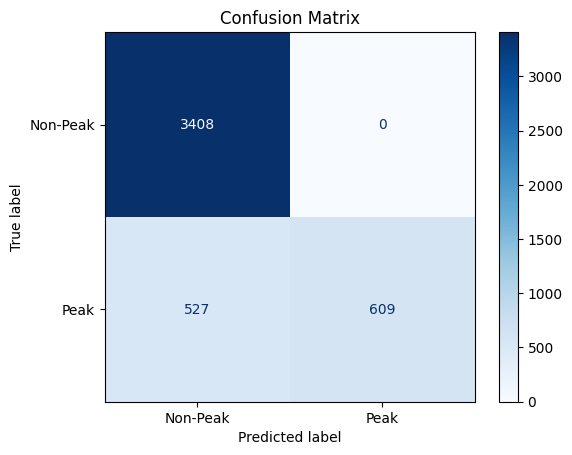

In [74]:
"""# Classification Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Peak', 'Peak'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()"""

In [75]:
"""y_test.shape"""

(4544,)

In [75]:
#Use independently trained model 10 times as an ensemble
from sklearn.metrics import accuracy_score

def train_and_evaluate_model(model_func, X_train, y_train, X_val, y_val, X_test, y_test, epochs=3):
    # Create and compile the model
    model = model_func()
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    # Predict on test data
    y_pred = model.predict(X_test)
    return y_pred

# Number of models in the ensemble
num_models = 10

# Store predictions from each model
ensemble_predictions = []

for i in range(num_models):
    print(f"Training model {i+1}/{num_models}")
    y_pred = train_and_evaluate_model(create_CNN, X_train, y_train, X_val, y_val, X_test, y_test, epochs=15)
    ensemble_predictions.append(y_pred)

# Average the predictions
average_predictions = np.mean(ensemble_predictions, axis=0)

# Convert averaged predictions to binary output
average_predictions_binary = (average_predictions >= 0.5).astype(int)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, average_predictions_binary)
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")
